In [1]:
# Computations
import pandas as pd
import numpy as np

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
from plotly import tools
import plotly.express as px
import plotly.figure_factory as ff
# Graphics in retina format 
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings('ignore')

<div class='alert alert-success' role='alert'>
<font size='+2'><b>Statlog (German Credit Data) Dataset</b></font>
</div>

In this article, we analyze the [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) Statlog (german credit data) from [Kaggle.com](
https://www.kaggle.com/uciml/german-credit).

## Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## Content
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [2]:
Data = pd.read_csv('Data/german_credit_data.csv', index_col=0)

def Data_info(Inp, Only_NaN = False):
    Out = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = Out.join(Inp.isnull().sum().to_frame(name = 'Number of NaN Values'), how='outer')
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    if Only_NaN:
        Out = Out.loc[Out['Number of NaN Values']>0]
    return Out
#
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'The Dataset:')
display(Data.head())
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Nan Values:')
display(Data_info(Data))
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Dataset Shape:')
display(pd.DataFrame([Data.shape], columns = ['Instances','Attributes'],index = ['Dataset']))

The Dataset:


Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

Nan Values:


Data Type  Number of NaN Values  Percentage
Age                  int64                     0         0.0
Checking account    object                   394        39.4
Credit amount        int64                     0         0.0
Duration             int64                     0         0.0
Housing             object                     0         0.0
Job                  int64                     0         0.0
Purpose             object                     0         0.0
Risk                object                     0         0.0
Saving accounts     object                   183        18.3
Sex                 object                     0         0.0

Dataset Shape:


Instances  Attributes
Dataset       1000          10

# Preprocessing

In [3]:
Data['Sex'] = Data['Sex'].map(lambda x: x.title())
Data['Housing'] = Data['Housing'].map(lambda x: x.title())
Data['Checking account'] = Data['Checking account'].fillna('None')
Data['Checking account'] = Data['Checking account'].map(lambda x: x.title())
Data['Saving accounts'] = Data['Saving accounts'].fillna('None')
Data['Saving accounts'] = Data['Saving accounts'].map(lambda x: x.title())
Data['Purpose'] = Data['Purpose'].map(lambda x: x.title())
Data['Purpose'] = Data['Purpose'].replace({'Radio/Tv':'Radio/TV'})
Data['Risk'] = Data['Risk'].map(lambda x: x.title())
Data.columns = [x.title() for x in Data.columns]
Data.head()

Age     Sex  Job Housing Saving Accounts Checking Account  Credit Amount  \
0   67    Male    2     Own            None           Little           1169   
1   22  Female    2     Own          Little         Moderate           5951   
2   49    Male    1     Own          Little             None           2096   
3   45    Male    2    Free          Little           Little           7882   
4   53    Male    2    Free          Little           Little           4870   

   Duration              Purpose  Risk  
0         6             Radio/TV  Good  
1        48             Radio/TV   Bad  
2        12            Education  Good  
3        42  Furniture/Equipment  Good  
4        24                  Car   Bad

### Age Group and Age Category

Creating new features:

* **Age Group**
* **Age Category**

We create [**statcan.gc.ca**](https://www.statcan.gc.ca/eng/concepts/definitions/age2) Age Category.

| Interval | Age Category |
|--------------------------------------------|-----------------------------------|
| 00-14 years  | Children  |
| 15-24 years  | Youth  |
| 25-64 years  | Adults  |
| 65 years and over  | Seniors  |

In [4]:
if Data.Age.min() < 14:
    bins = pd.IntervalIndex.from_tuples([(0, 14), (14, 24), (24, 64),(64, Data.Age.max())])
else:
    bins = pd.IntervalIndex.from_tuples([(14, 24), (24, 64),(64, Data.Age.max())])
Data['Age Category'] = pd.cut(Data['Age'], bins).astype(str).\
                        replace({'(14, 24]':'Youth', '(24, 64]':'Adults','(64, 75]':'Seniors'})
Data.head()

Age     Sex  Job Housing Saving Accounts Checking Account  Credit Amount  \
0   67    Male    2     Own            None           Little           1169   
1   22  Female    2     Own          Little         Moderate           5951   
2   49    Male    1     Own          Little             None           2096   
3   45    Male    2    Free          Little           Little           7882   
4   53    Male    2    Free          Little           Little           4870   

   Duration              Purpose  Risk Age Category  
0         6             Radio/TV  Good      Seniors  
1        48             Radio/TV   Bad        Youth  
2        12            Education  Good       Adults  
3        42  Furniture/Equipment  Good       Adults  
4        24                  Car   Bad       Adults

In [5]:
Data_Type = Data_info(Data).iloc[:,:1]
display(Data_Type.T)
Temp = Data_Type.loc[Data_Type['Data Type'] == 'object'].index.tolist()
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Categorical Features:'+ Style.RESET_ALL + ' %s:'
      % ', '.join(Temp))

Age Age Category Checking Account Credit Amount Duration Housing  \
Data Type  int64       object           object         int64    int64  object   

             Job Purpose    Risk Saving Accounts     Sex  
Data Type  int64  object  object          object  object

Categorical Features: Age Category, Checking Account, Housing, Purpose, Risk, Saving Accounts, Sex:


We can convert Age Category, Checking Account, Housing, Risk, Saving Accounts, and Sex as follows
\begin{align}
&\mbox{Age Category} = 
\begin{cases}
0, \mbox{Youth},\\
1, \mbox{Adults},\\
2, \mbox{Seniors}.
\end{cases},&
&\mbox{Checking Account} =
\begin{cases}
0, \mbox{None},\\
1, \mbox{Little},\\
2, \mbox{Moderate},\\
3, \mbox{Rich}.
\end{cases},&
\\
&\mbox{Housing} = \begin{cases}
0, \mbox{Free},\\
1, \mbox{Rent},\\
2, \mbox{Own,}
\end{cases},&
&\mbox{Risk} = \begin{cases}
0, \mbox{Bad},\\
1, \mbox{Good}.
\end{cases},&
\\
&\mbox{Saving Accounts} =
\begin{cases}
0, \mbox{None},\\
1, \mbox{Little},\\
2, \mbox{Moderate},\\
3, \mbox{Rich}.
\end{cases},&
&\mbox{Sex} = 
\begin{cases}
0, \mbox{Female},\\
1, \mbox{Male}.
\end{cases}.&
\end{align}

Moreover, **Purpose** can be converted as a dummy variable.

In [6]:
df = Data.copy()
df = df.drop(columns = ['Age'])
df['Age Category'] = df['Age Category'].replace({'Youth':0, 'Adults': 1, 'Seniors':2}).astype(int)
df['Checking Account'] = df['Checking Account'].replace({'None':0, 'Little': 1, 'Moderate':2, 'Rich':3}).astype(int)
df['Housing'] = df['Housing'].replace({'Free':0, 'Rent': 1, 'Own':2}).astype(int)
df['Risk'] = df['Risk'].replace({'Bad':0, 'Good':1}).astype(int)
df['Saving Accounts'] = df['Saving Accounts'].replace({'None':0, 'Little': 1, 'Moderate':2,
                                                           'Rich':3, 'Quite Rich':4}).astype(int)
df['Sex'] = df['Sex'].replace({'Female':0, 'Male':1}).astype(int)

Temp = df.drop(columns = ['Purpose'])
df = pd.concat([Temp, pd.get_dummies(df['Purpose'])], axis = 1)
del Temp

# Modeling

## Data Correlations

First off, let's define $X$ and $y$ sets.

In [7]:
Target = 'Risk'
X = df.drop(columns = [Target])
y = df[Target]

Now, let's take a look at the variance of the features.

In [8]:
display(X.var().sort_values(ascending = False).to_frame(name= 'Variance').T.style.set_precision(2))

As can see some of the variables have high variance and this is not desirable for our modeling. Thus, we would like to standardize features by removing the mean and scaling to unit variance. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification.html), we demonstrated the benefits of scaling data using [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [9]:
Temp = X.columns
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns = Temp)
del Temp

Correlations of features with **Class**.

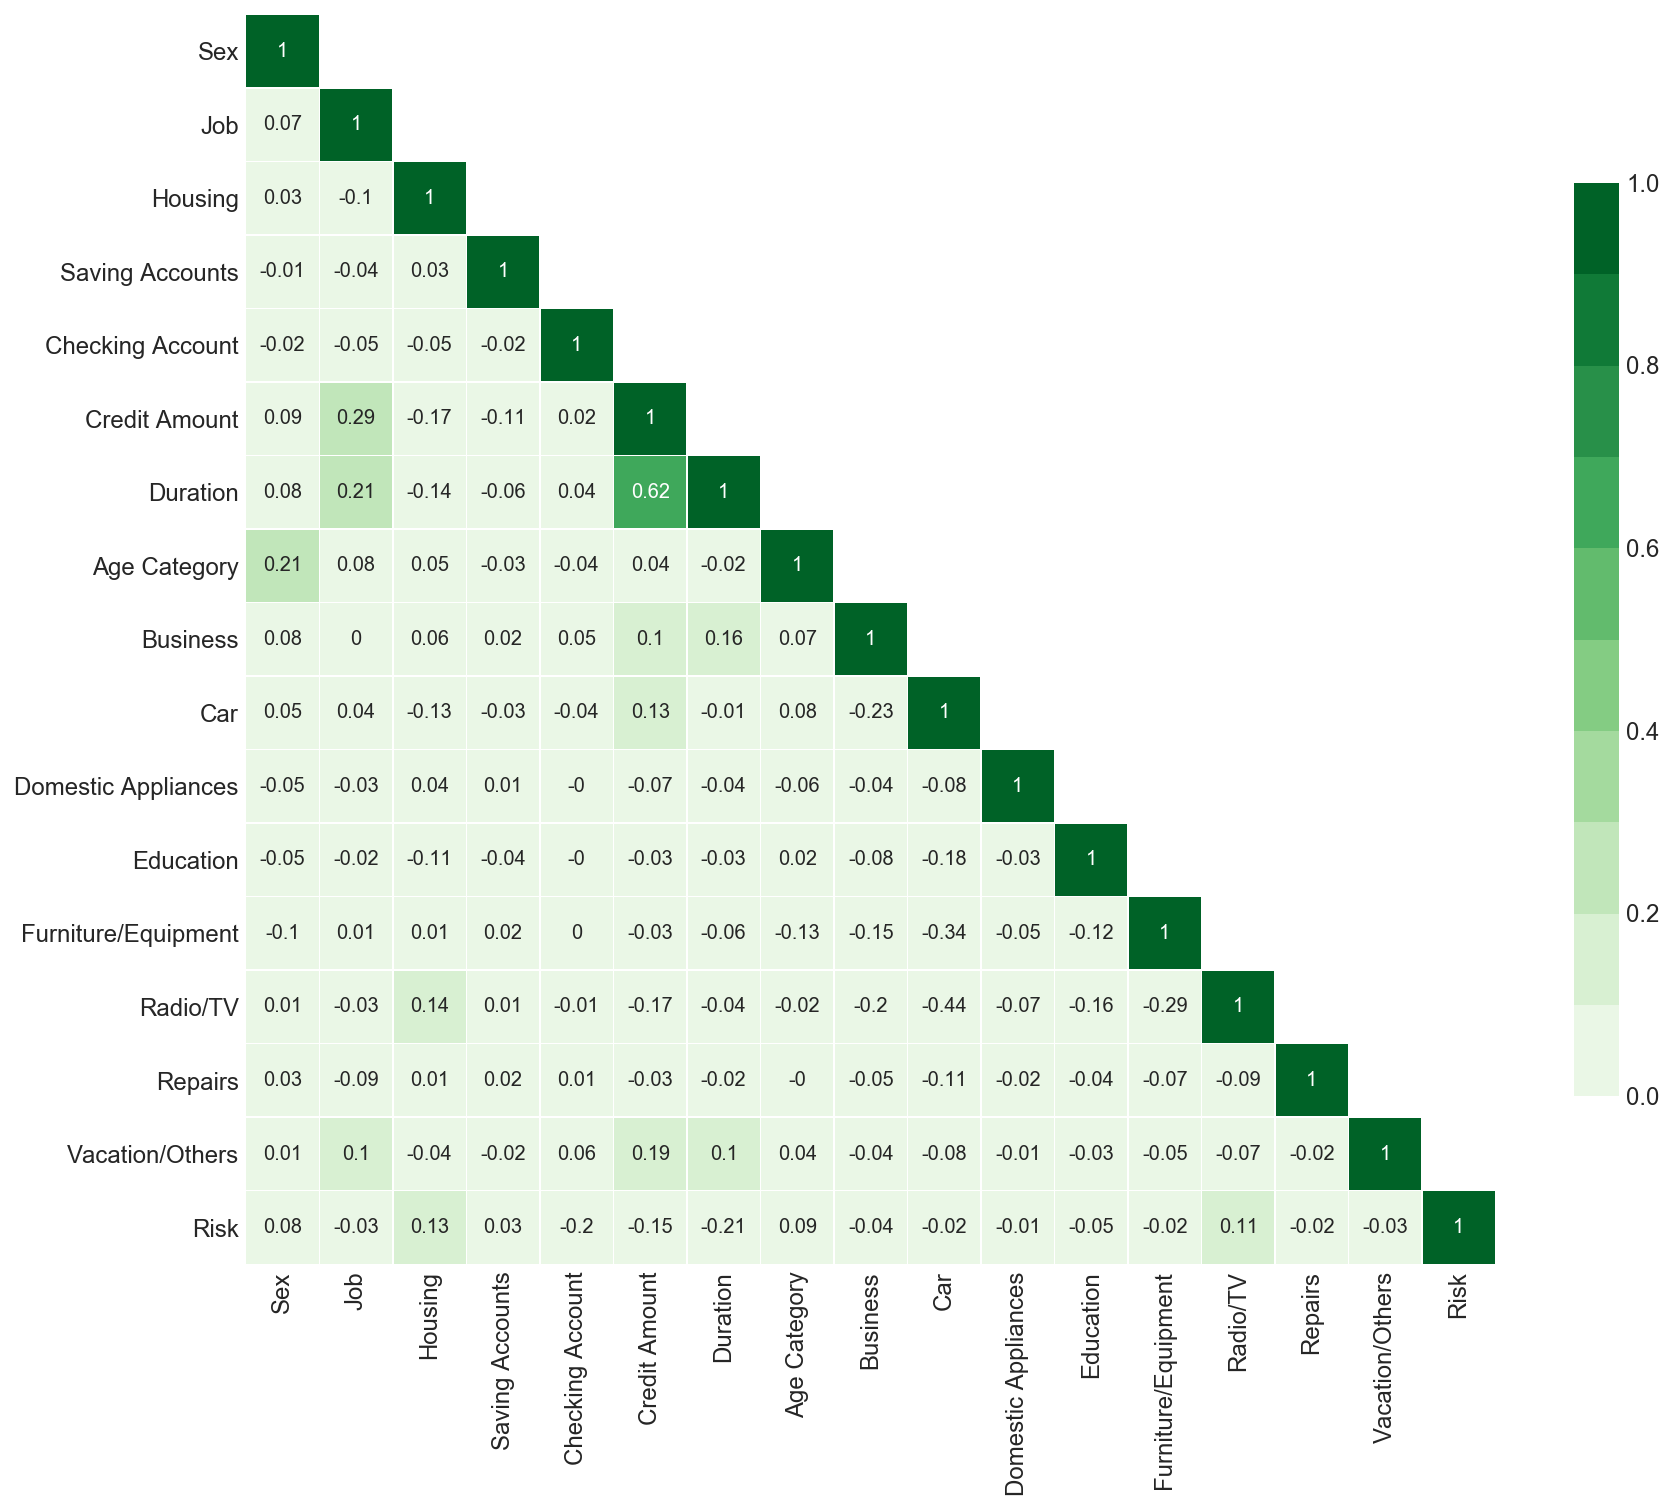

In [10]:
Temp = pd.DataFrame(X, columns = df.drop(columns = [Target]).columns)
Temp[Target] = y

def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr().round(2)
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("Greens", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .6})

Correlation_Plot (Temp, 14)

## Train and Test Sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set      X_train     X_test y_train  y_test
Shape  (700, 16)  (300, 16)  (700,)  (300,)

In [12]:
def Performance(clf, X_test = X_test):
    df = pd.DataFrame()
    y_pred = clf.predict(X_test)
    df = df.append({'Score': clf.score(X_test, y_test),
                    'F1 Score': f1_score(y_test.values, y_pred, average= 'weighted'),
                    'Precision Score': precision_score(y_test.values, y_pred, average= 'weighted'),
                    'Recall Score':  recall_score(y_test.values, y_pred, average= 'weighted')}, ignore_index=True)
    display(df.style.hide_index())

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: SpringGreen' if v else '' for v in is_max]


def Feature_Ranking(clf):
    df = pd.DataFrame()
    for n in range(2, X.shape[1]):
        selector = RFE(estimator= clf, n_features_to_select=n, verbose=0)
        selector.fit(X_train, y_train)
        df = df.append({'Number of Features to Select': n,
                        'Score':accuracy_score(y_test, selector.predict(X_test)),
                        'Features': X.columns[selector.support_].tolist(),
                        'Best Features':X.columns[selector.ranking_ == 1].tolist()}, ignore_index=True)

    df = df[['Number of Features to Select', 'Score', 'Features', 'Best Features']]
    display(df.style.apply(highlight_max, subset=['Score']))
    return df.loc[df.Score == df.Score.max(), 'Features'].values[0]

def ROC_Curve(clf, X_test = X_test):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    delta = 0.01
    _ = ax.set_xlim([-delta,1+delta])
    _ = ax.set_ylim([-delta,1+delta])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')

## Decision Tree Classifier

The first classifier that we use here is [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

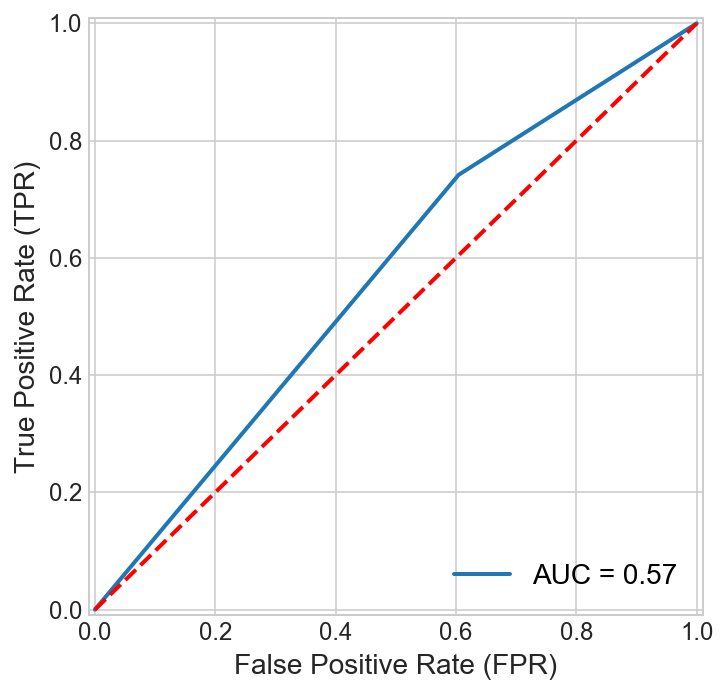

In [13]:
dtc = DecisionTreeClassifier()
_ = dtc.fit(X_train,y_train)
Performance(dtc)
ROC_Curve(dtc)

However, we could also use RFE from [sklearn.feature_selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). This provides feature ranking with recursive feature elimination.

In [14]:
Best_Features = Feature_Ranking(dtc)

In [15]:
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Best Features:'+ Style.RESET_ALL + ' %s:' % ', '.join(Best_Features))

Best Features: Sex, Job, Housing, Saving Accounts, Checking Account, Credit Amount, Duration, Car:


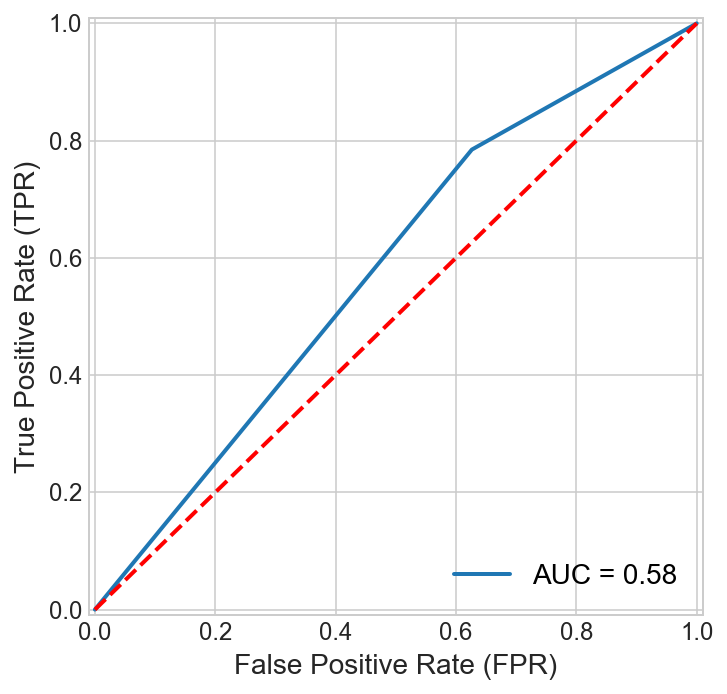

In [16]:
dtc = DecisionTreeClassifier()
_ = dtc.fit(X_train[Best_Features],y_train)
Performance(dtc, X_test[Best_Features])
ROC_Curve(dtc, X_test[Best_Features])

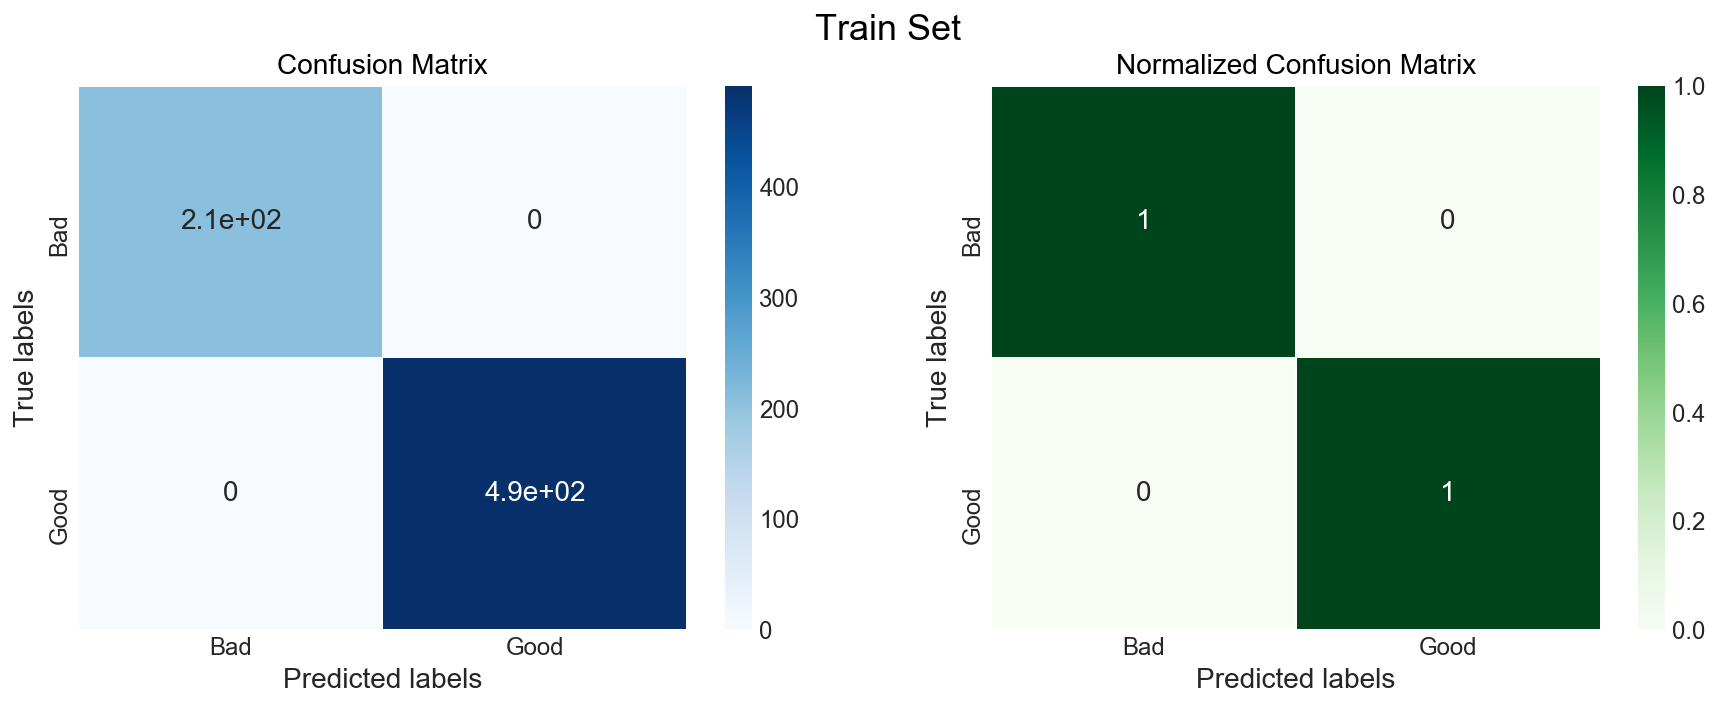

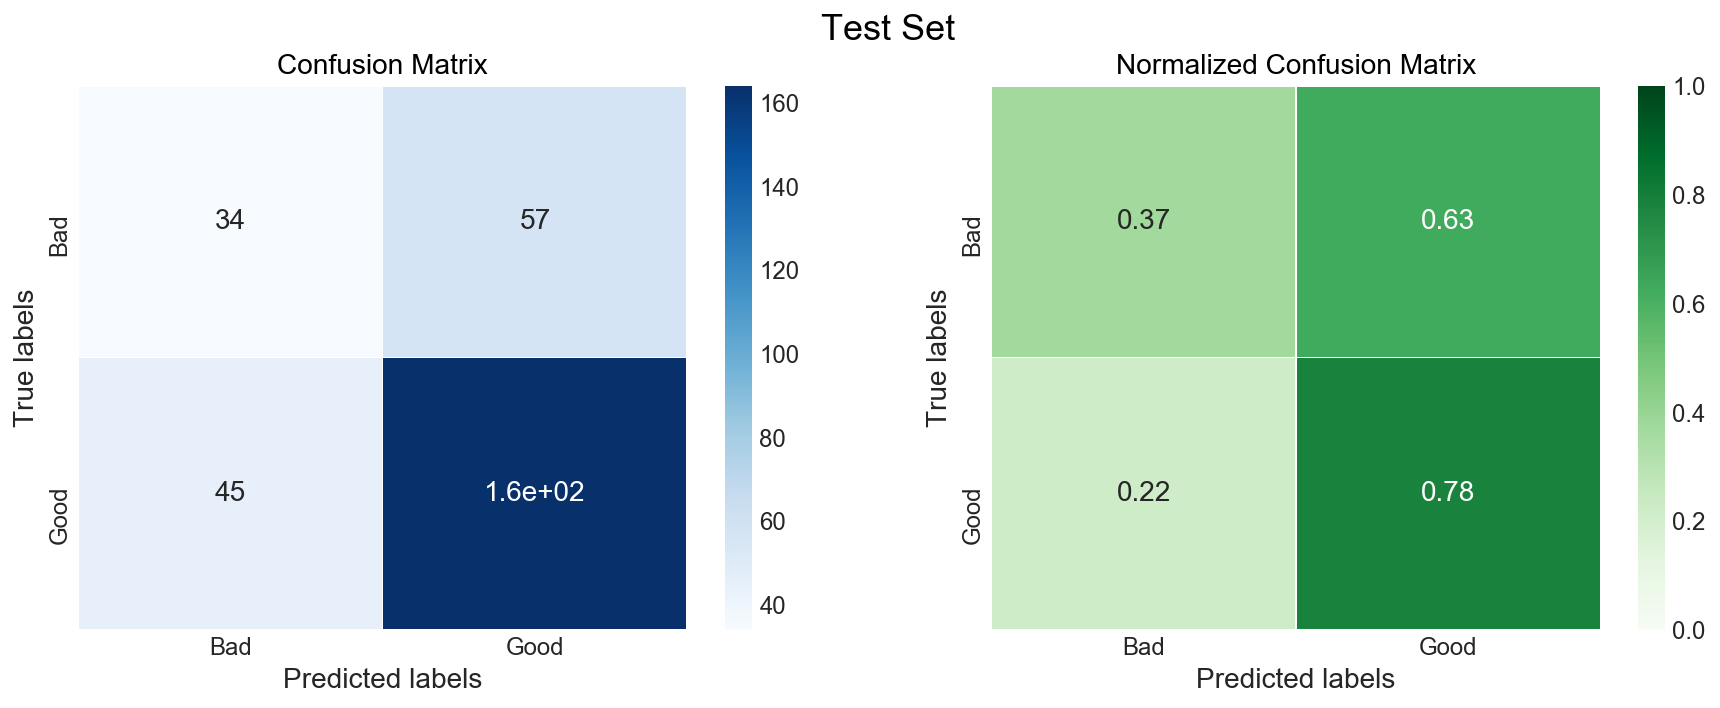

In [17]:
Labels = np.sort(Data.Risk.unique().tolist())
# Train set
y_pred = dtc.predict(X_train[Best_Features])
Confusion_Matrix = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
               linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Test set
y_pred = dtc.predict(X_test[Best_Features])
Confusion_Matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

**RFE** can be very useful, especially for cases that the number of features is quite large.

## Random Forest Classifier

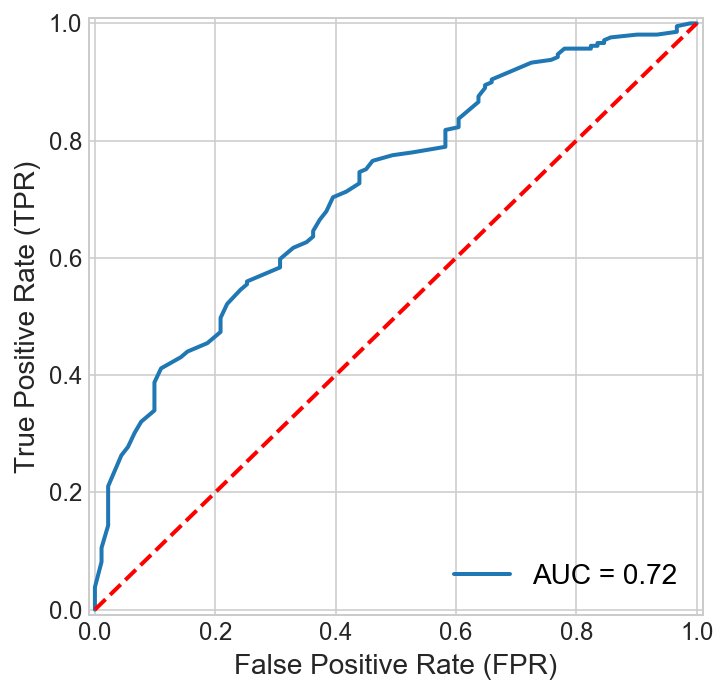

In [18]:
rfc = RandomForestClassifier()
_ = rfc.fit(X_train,y_train)
Performance(rfc)
ROC_Curve(rfc)

In [19]:
Best_Features = Feature_Ranking(rfc)

Thus, we could use only fewer features and improve the results of classifications. The best features for the classifications are

In [20]:
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Best Features:'+ Style.RESET_ALL + ' %s:' % ', '.join(Best_Features))

Best Features: Sex, Job, Housing, Saving Accounts, Checking Account, Credit Amount, Duration, Car:


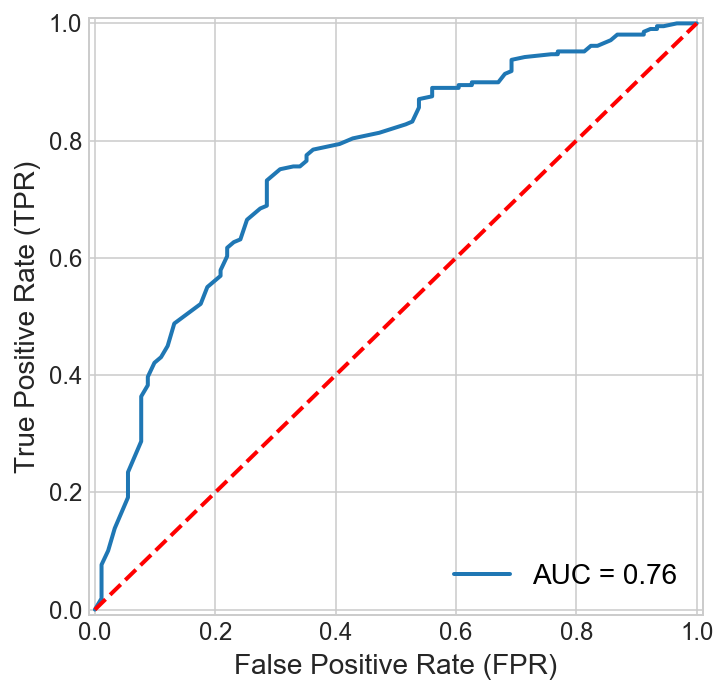

In [21]:
rfc = RandomForestClassifier()
_ = rfc.fit(X_train[Best_Features],y_train)
Performance(rfc, X_test[Best_Features])
ROC_Curve(rfc, X_test[Best_Features])

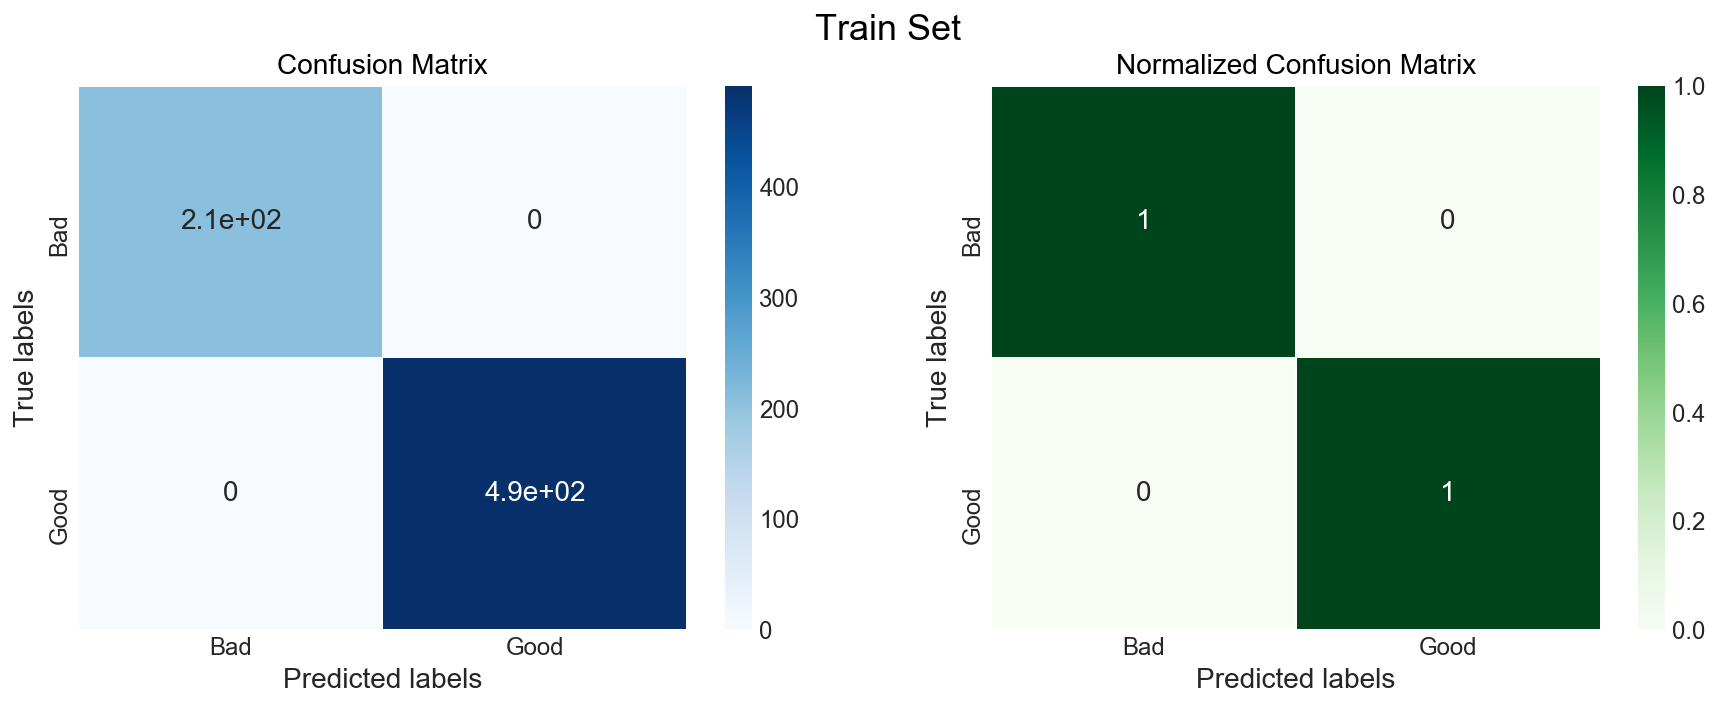

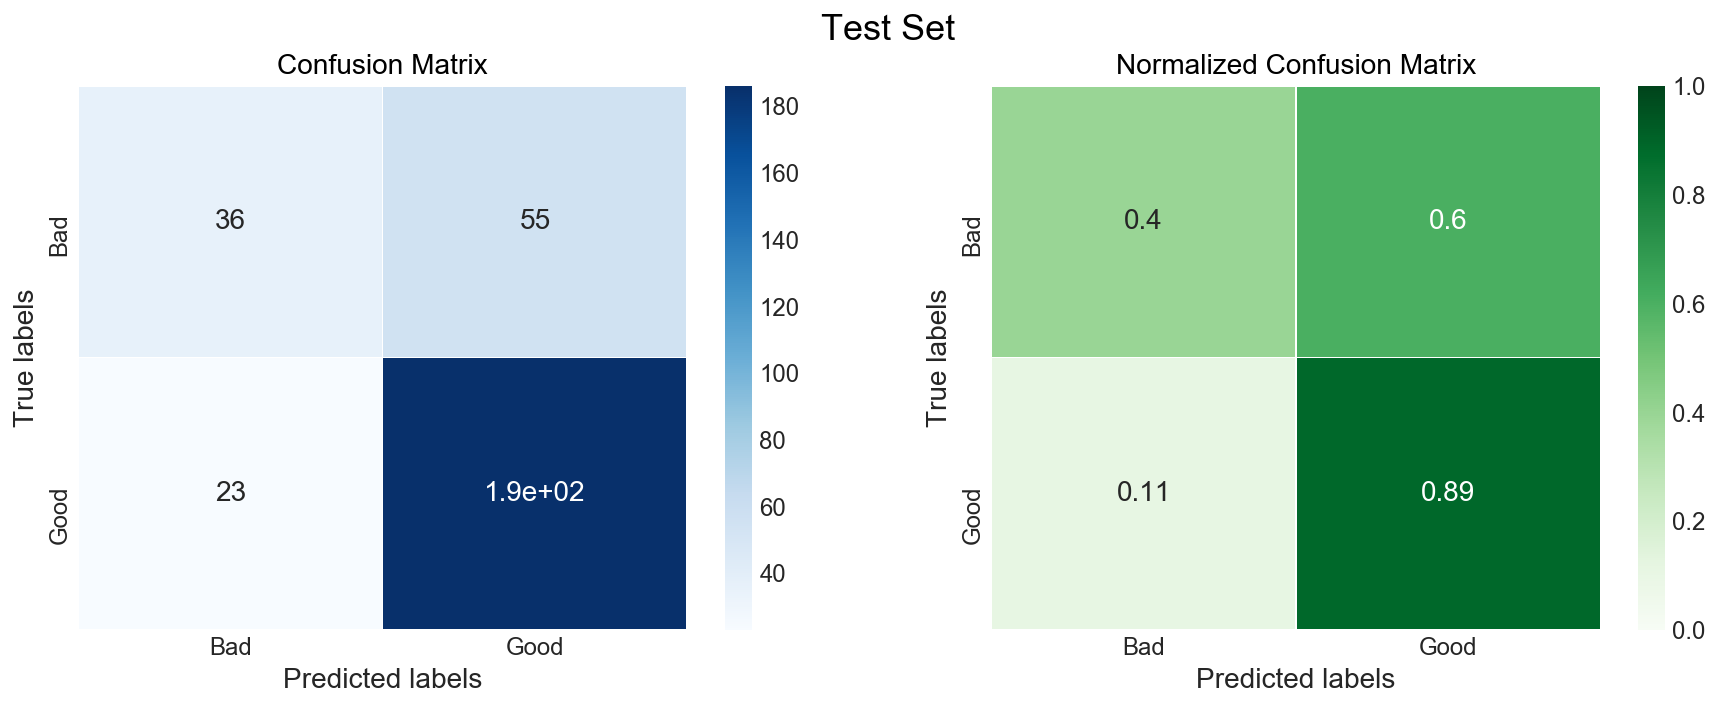

In [22]:
# Train set
y_pred = rfc.predict(X_train[Best_Features])
Confusion_Matrix = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
               linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Test set
y_pred = rfc.predict(X_test[Best_Features])
Confusion_Matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

It can be seen overall, Random Forest Classifier performed better in this example. Furthermore, using RFE improves the accuracy of this classification.